# Studying the output of the MultiCoincidenceFinder

In [1]:
import ROOT 
import math
c = ROOT.TCanvas()
f = ROOT.TFile('coincidences380Fills.root')
t = f.Get('testCoincidenceFinder/t')
ROOT.gStyle.SetOptStat(0)

Welcome to JupyROOT 6.08/02


In [2]:
# cut on difference between calo nums of clusters
def CaloDiffCut(clusterNums, diff):
    return ROOT.TCut('(((caloNum[{0}] - caloNum[{1}]) % 24) + 24) % 24 == {2}'.format(
        clusterNums[0], clusterNums[1], diff))

def TimeDiffCut(clusterNums, diff):
    return ROOT.TCut('clusterTime[{0}] - clusterTime[{1}] < {2}'.format(
        clusterNums[0], clusterNums[1], diff))

def CaloNumCut(calo_num):
    return ROOT.TCut('caloNum[0]=={}'.format(calo_num))
                     
# cut on coincidence level
def CLevel(level):
    return ROOT.TCut('coincidenceLevel=={}'.format(level))

def getDiffHist(diff, name):
    t.Draw('clusterTime[1] - clusterTime[0]>>{}(1000,0,20)'.format(name), 
           CLevel(2) + CaloDiffCut((1,0),diff))
    return ROOT.gROOT.FindObject(name)

ecut1 = ROOT.TCut('clusterEnergy[0]>100 && clusterEnergy[0]<500')
ecut2 = ROOT.TCut('clusterEnergy[1]>100 && clusterEnergy[1]<500')
def getDiffHistMuonCuts(diff, name):
    t.Draw('clusterTime[1] - clusterTime[0]>>{}(1000,0,20)'.format(name), 
           CLevel(2)+CaloDiffCut((1,0),diff)+ecut1+ecut2)
    return ROOT.gROOT.FindObject(name)

def get2dHistMuonCuts(diff, name):
    ecut1 = ROOT.TCut('clusterEnergy[0]>100 && clusterEnergy[0]<500')
    ecut2 = ROOT.TCut('clusterEnergy[1]>100 && clusterEnergy[1]<500')
    t.Draw('clusterTime[1] - clusterTime[0]:clusterTime[0]>>{}(1000,0,50000,100,0,20)'.format(name), 
           CLevel(2)+CaloDiffCut((1,0),diff)+ecut1+ecut2)
    return ROOT.gROOT.FindObject(name)

def timeMuonCuts(name):
    ecut1 = ROOT.TCut('clusterEnergy[0]>100 && clusterEnergy[0]<500')
    ecut2 = ROOT.TCut('clusterEnergy[1]>100 && clusterEnergy[1]<500')
    t.Draw('clusterTime[0]>>{}(100,0,50000)'.format(name), 
           CLevel(2)+CaloDiffCut((1,0),1)+ecut1+ecut2+ROOT.TCut(
               '(clusterTime[1] - clusterTime[0] > 4) && (clusterTime[1] - clusterTime[0] < 6)'))
    return ROOT.gROOT.FindObject(name)

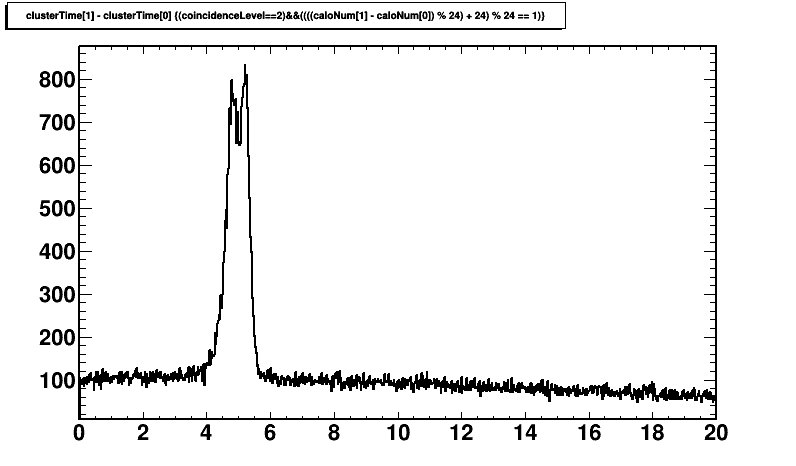

In [3]:
d1 = getDiffHist(1, 'diff1')
d1.Draw()
c.Draw()

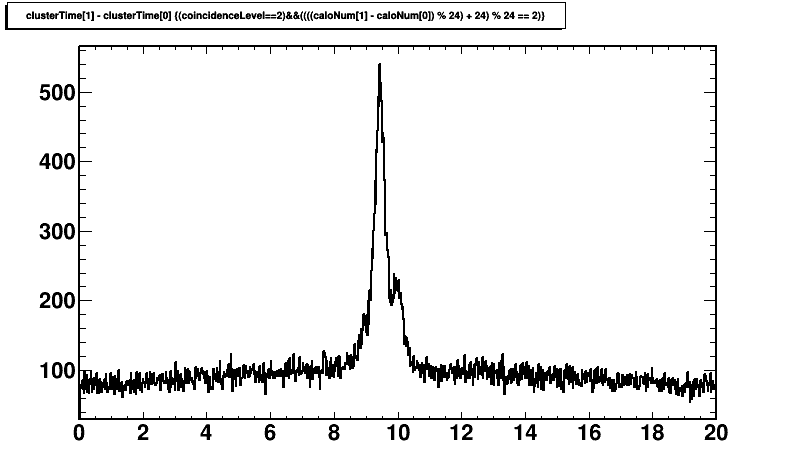

In [4]:
d2 = getDiffHist(2, 'diff2')
d2.Draw()
c.Draw()

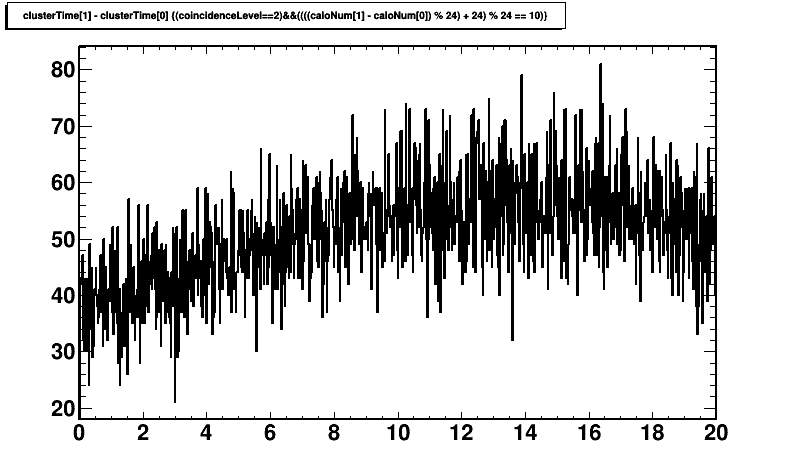

In [5]:
d10 = getDiffHist(10, 'diff10')
d10.Draw()
c.Draw()

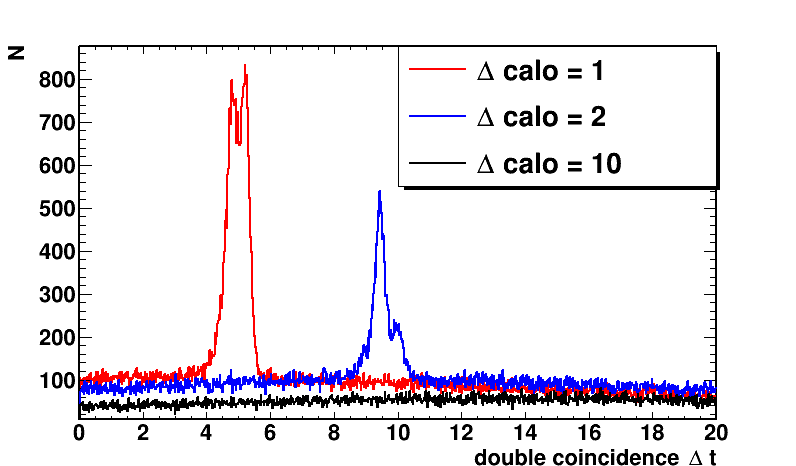

In [6]:
d1.SetLineColor(ROOT.kRed)
d1.SetTitle('double coincidences')
d2.SetLineColor(ROOT.kBlue)
ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
d1.Draw()
d2.Draw("same")
d10.Draw("same")
d1.SetTitle(';double coincidence #Delta t; N')
leg = ROOT.TLegend(0.5, 0.9, 0.9, 0.6)
leg.AddEntry(d1, '#Delta calo = 1', 'l')
leg.AddEntry(d2, '#Delta calo = 2', 'l')
leg.AddEntry(d10, '#Delta calo = 10', 'l')
leg.Draw()
c.Draw()

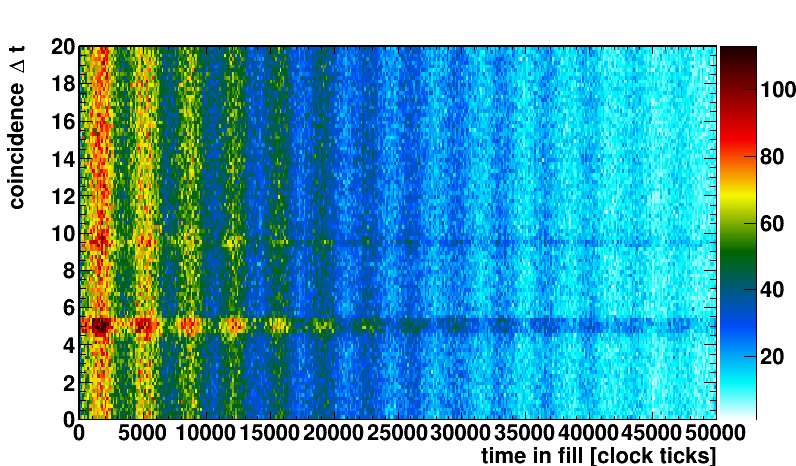

In [7]:
t.Draw("clusterTime[1] - clusterTime[0]:clusterTime[0]>>timeDiffVsT(400,0,50000,100,0,20)",CLevel(2),"colz")
ROOT.gROOT.FindObject('timeDiffVsT').SetTitle(';time in fill [clock ticks]; coincidence #Delta t')
c.Draw()

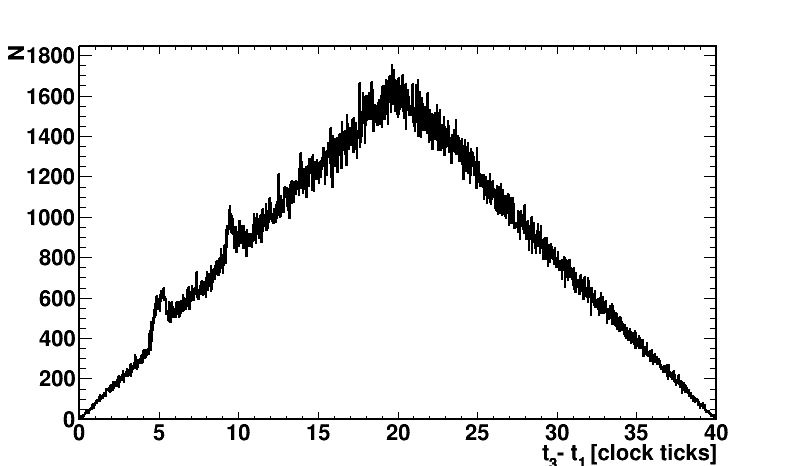

In [8]:
t.Draw("clusterTime[2] - clusterTime[0]>>tripleTimeDiff(2000,0,40)",CLevel(3))
ROOT.gROOT.FindObject("tripleTimeDiff").SetTitle("triples;t_{3}- t_{1} [clock ticks]; N")
c.Draw()

# let's try to build an estimated double coincidence histogram

Expected number of double coincidences: $\int r^2 \delta t dt = N_0 \delta t / \tau \int exp(-2t/\tau)dt$

$\delta t$ is the time window for coincidence.

In the case of a histogram, $r \sim \frac{N}{n_{fills} bin width}$

For this study, we will only look at $\Delta caloNum = 1$, but we will look at all calos. This means the $r^2$ should include a single factor of $1/24$.  

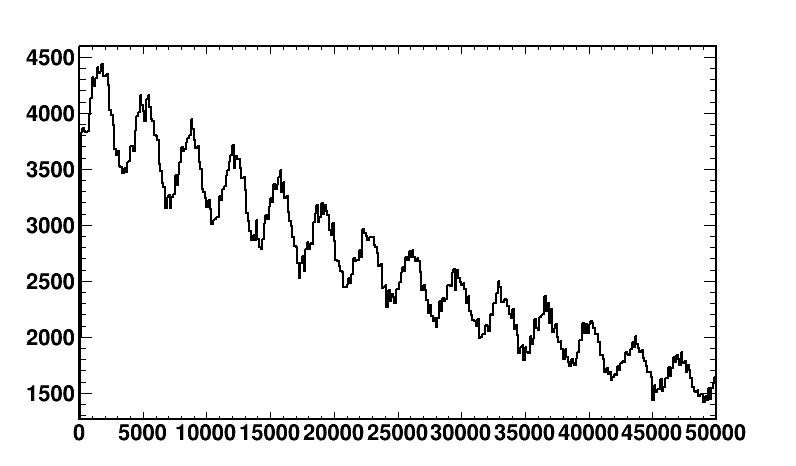

In [9]:
# first average over all times
t.Draw("clusterTime[0]>>singleTimesAllCalos(400,0,50000)",CLevel(1))
stAll=ROOT.gROOT.FindObject('singleTimesAllCalos')
nClustersTot = stAll.Integral()
c.Draw()

In [10]:
# build rate in single calo from stAll
nextCaloCoins = ROOT.TH1D("nextCaloCoins", "nextCaloCoins", 400, 0, 50000)

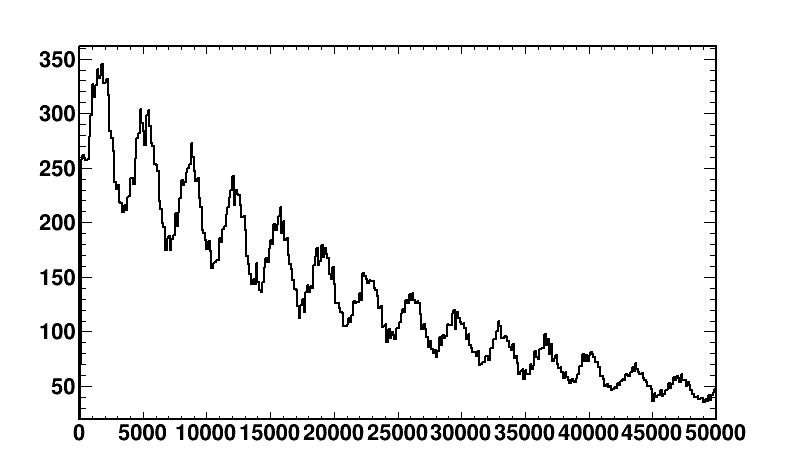

In [11]:
for i in xrange(stAll.GetNbinsX() + 1):
    st_n = stAll.GetBinContent(i)
    sc_rate = st_n / 380.0 / (50000.0/400)/24
    nextCaloCoins.SetBinContent(i, sc_rate*20*st_n)
nextCaloCoins.Draw()
c.Draw()

## This really should be done on calo by calo basis, but I don't have enough statistics. I'll just do the average over all calos and all $\Delta$ calo, which means I must scale up my estimate by 23. Not 24, because I'm not including coincidences within the same calorimeter

In [12]:
nextCaloCoins.Scale(23)

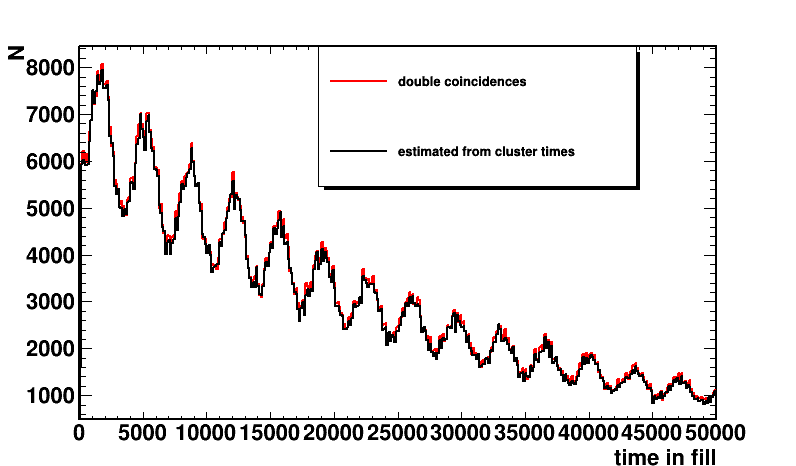

In [13]:
t.Draw("clusterTime[0]>>measuredAllCaloDouble(400,0,50000)", CLevel(2))
mac = ROOT.gROOT.FindObject('measuredAllCaloDouble')
mac.SetLineColor(ROOT.kRed)
mac.SetTitle('coincidence, delta calo = 1;time in fill; N')
mac.Draw("hist")
nextCaloCoins.Draw("same hist")
leg = ROOT.TLegend(0.4,0.9,0.8,0.6)
leg.AddEntry(mac, 'double coincidences', 'l')
leg.AddEntry(nextCaloCoins, 'estimated from cluster times', 'l')
leg.Draw()
c.Draw()

**Try same exercise with triples.**

In [14]:
# build rate in single calo from stAll
triplecaloest = ROOT.TH1D("triplecaloest", "triplecaloest", 400, 0, 50000)

In [15]:
for i in xrange(stAll.GetNbinsX() + 1):
    st_n = stAll.GetBinContent(i)
    sc_rate = st_n / 380.0 / (50000.0/400)*23.0/24
    triplecaloest.SetBinContent(i, sc_rate**2*20**2*st_n)

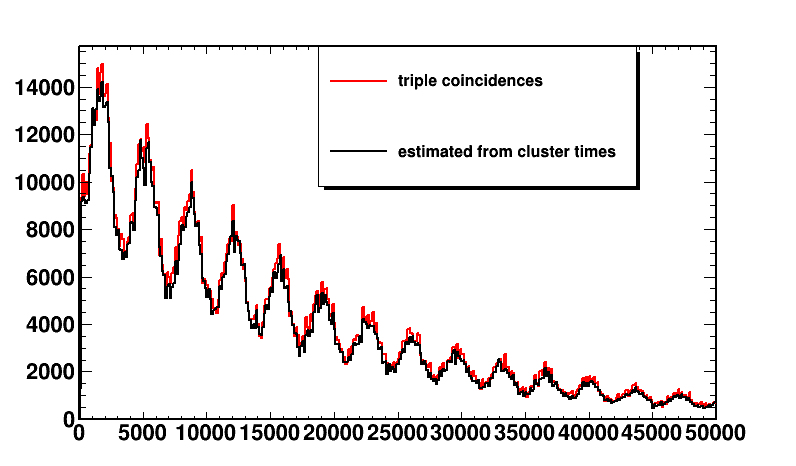

In [16]:
t.Draw("clusterTime[0]>>measuredtrip(400,0,50000)", CLevel(3))
mt = ROOT.gROOT.FindObject("measuredtrip")
mt.SetLineColor(ROOT.kRed)
mt.Draw()
triplecaloest.Draw("same")
leg = ROOT.TLegend(0.4,0.9,0.8,0.6)
leg.AddEntry(mt, 'triple coincidences', 'l')
leg.AddEntry(triplecaloest, 'estimated from cluster times', 'l')
leg.Draw()
c.Draw()

In [17]:
# estimate background before scaling down the hist
bg_est = nextCaloCoins.Integral()/24
bg_f = ROOT.TF1('bgf', '{}/1000'.format(bg_est),0,1000)
bg_f.SetLineColor(ROOT.kMagenta + 2)
bg_f.SetLineWidth(3)

## plot singles, triples, doubles normalized by area

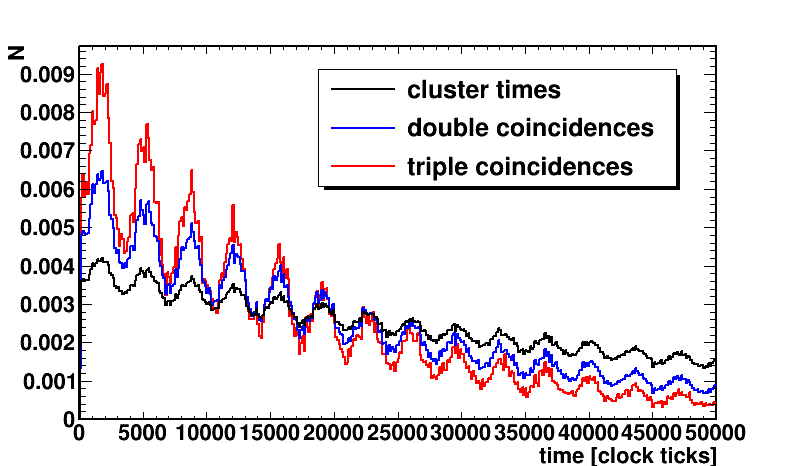

In [18]:
stAll.Scale(1.0/stAll.Integral())
mt.Scale(1.0/mt.Integral())
nextCaloCoins.Scale(1.0/nextCaloCoins.Integral())
mt.SetLineColor(ROOT.kRed)
mt.Draw("hist")
mt.SetTitle(';time [clock ticks]; N')
nextCaloCoins.SetLineColor(ROOT.kBlue)
nextCaloCoins.Draw("same hist")
stAll.SetLineColor(ROOT.kBlack)
stAll.Draw("same hist")
leg = ROOT.TLegend(0.4, 0.85, 0.85, 0.6)
leg.AddEntry(stAll, 'cluster times', 'l')
leg.AddEntry(nextCaloCoins, 'double coincidences', 'l')
leg.AddEntry(mt, 'triple coincidences', 'l')
leg.Draw()
c.Draw()

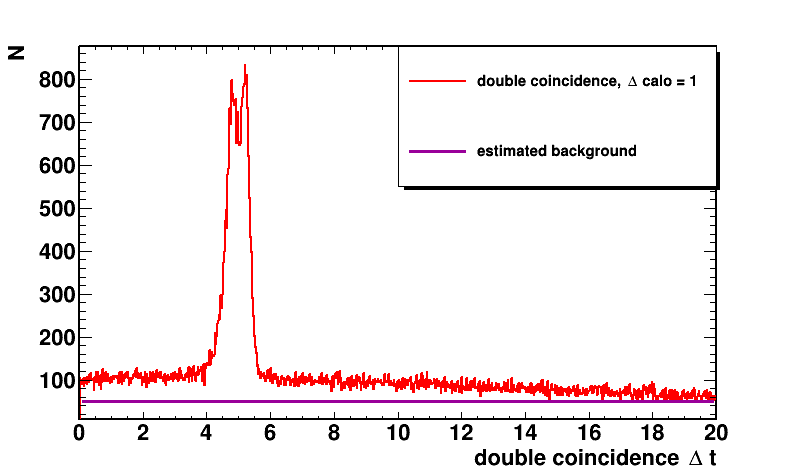

In [19]:
# back to where we started
d1.Draw()
bg_f.Draw("same")
leg = ROOT.TLegend(0.5, 0.9, 0.9, 0.6)
leg.AddEntry(d1, 'double coincidence, #Delta calo = 1', 'l')
leg.AddEntry(bg_f, 'estimated background', 'l')
leg.Draw()
c.Draw()

In [20]:
bg_f.SetLineColor(ROOT.kMagenta + 2)
bg_f.SetLineWidth(3)

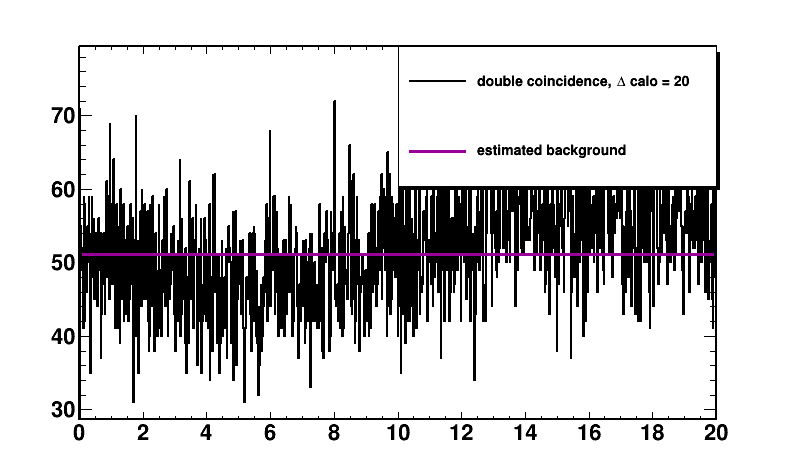

In [21]:
ROOT.gStyle.SetOptTitle(0)
d20 = getDiffHist(20,'d20')
d20.SetTitle(d1.GetTitle())
d20.Draw()
bg_f.Draw("same")
leg = ROOT.TLegend(0.5, 0.9, 0.9, 0.6)
leg.AddEntry(d20, 'double coincidence, #Delta calo = 20', 'l')
leg.AddEntry(bg_f, 'estimated background', 'l')
leg.Draw()
c.Draw()

## background estimation seems to work for far away calos, but not $\Delta calo = 1$... wonder what's going on. Clearly not just random coincidence (even ignoring the giant spike)

## before worrying too much, I think it would be a good idea to get enough statistics to do this analysis on a per-calo basis, because that is how it will have to be done for real.

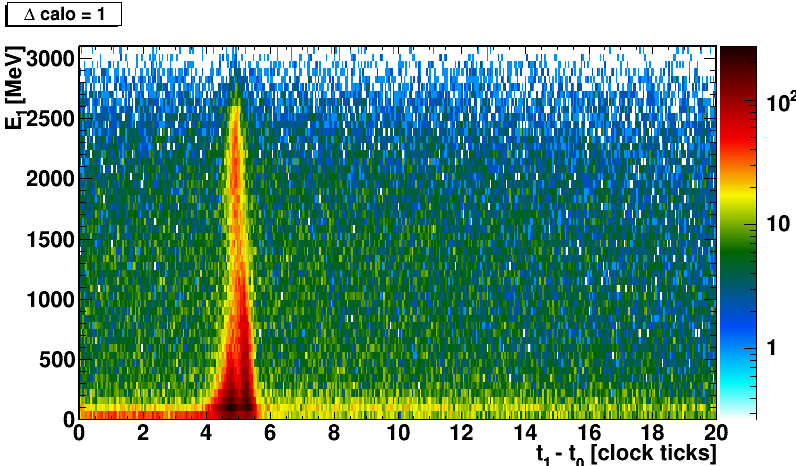

In [22]:
ROOT.gStyle.SetOptTitle(1)
t.Draw("clusterEnergy[0]:clusterTime[1]-clusterTime[0]>>evsdt(400,0,20,50,0,3100)",
       CaloDiffCut((1,0),1)+CLevel(2),'colz')
evsdt = ROOT.gROOT.FindObject('evsdt')
evsdt.SetTitle('#Delta calo = 1;t_{1} - t_{0} [clock ticks]; E_{1} [MeV]')
c.SetLogz(1)
c.Draw()

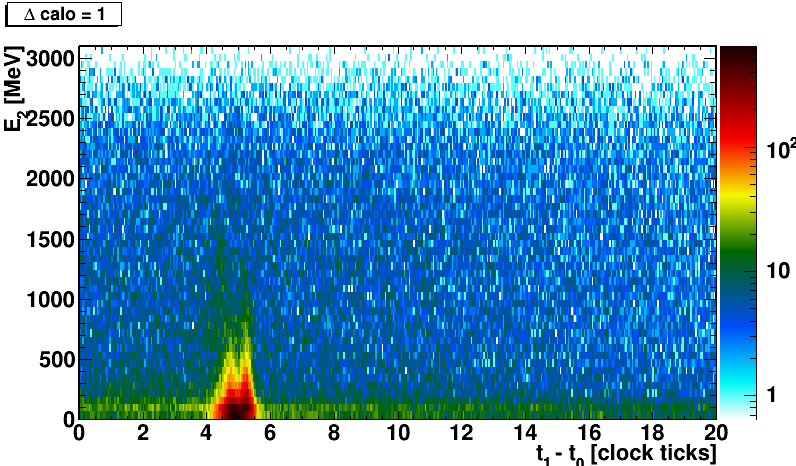

In [23]:
ROOT.gStyle.SetOptTitle(1)
t.Draw("clusterEnergy[1]:clusterTime[1]-clusterTime[0]>>evsdt(400,0,20,50,0,3100)",
       CaloDiffCut((1,0),1)+CLevel(2),'colz')
evsdt = ROOT.gROOT.FindObject('evsdt')
evsdt.SetTitle('#Delta calo = 1;t_{1} - t_{0} [clock ticks]; E_{2} [MeV]')
c.SetLogz(1)
c.Draw()

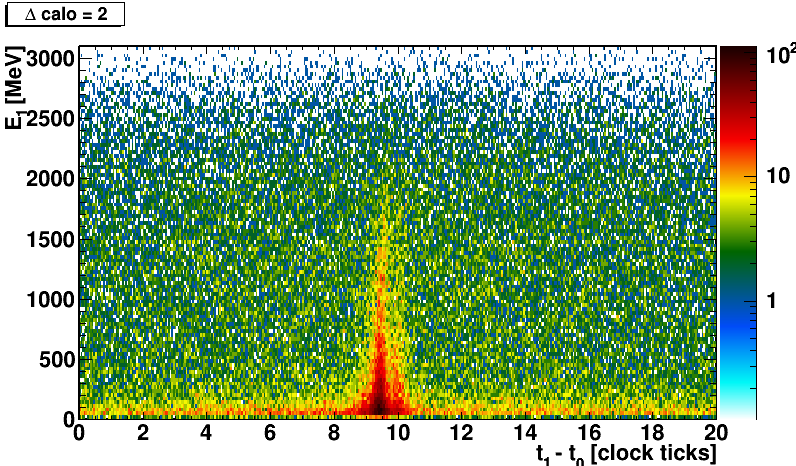

In [24]:
ROOT.gStyle.SetOptTitle(1)
t.Draw("clusterEnergy[0]:clusterTime[1]-clusterTime[0]>>evsdt2(400,0,20,100,0,3100)",
       CaloDiffCut((1,0),2)+CLevel(2),"colz")
evsdt = ROOT.gROOT.FindObject('evsdt2')
evsdt.SetTitle('#Delta calo = 2;t_{1} - t_{0} [clock ticks]; E_{1} [MeV]')
c.SetLogz(1)
c.Draw()

**look at farther away calo**

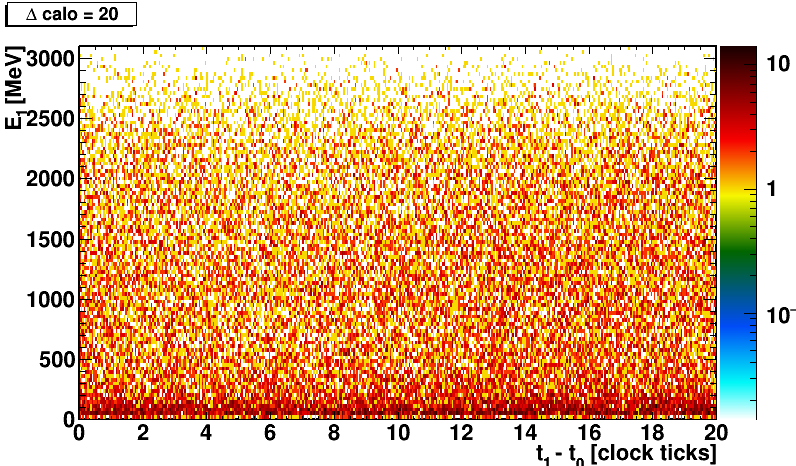

In [25]:
t.Draw("clusterEnergy[1]:clusterTime[1]-clusterTime[0]>>evsdt20(400,0,20,100,0,3100)",
       CaloDiffCut((1,0),20)+CLevel(2),"colz")
evsdt20 = ROOT.gROOT.FindObject('evsdt20')
evsdt20.SetTitle('#Delta calo = 20;t_{1} - t_{0} [clock ticks]; E_{1} [MeV]')
c.SetLogz(1)
c.Draw()

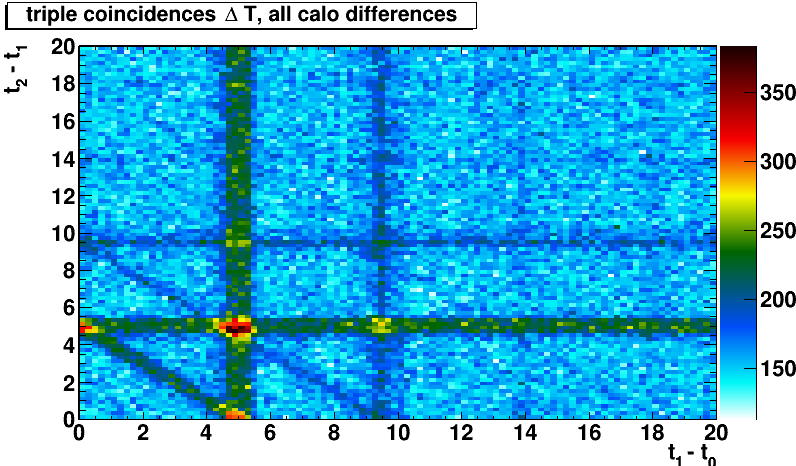

In [26]:
t.Draw("clusterTime[2]-clusterTime[1]:clusterTime[1]-clusterTime[0]>>2dtimings(100,0,20,100,0,20)", CLevel(3),"colz")
timings2d = ROOT.gROOT.FindObject('2dtimings')
timings2d.SetTitle('triple coincidences #Delta T, all calo differences;t_{1} - t_{0}; t_{2} - t_{1}')
c.SetLogz(0)
c.Draw()

6364.0

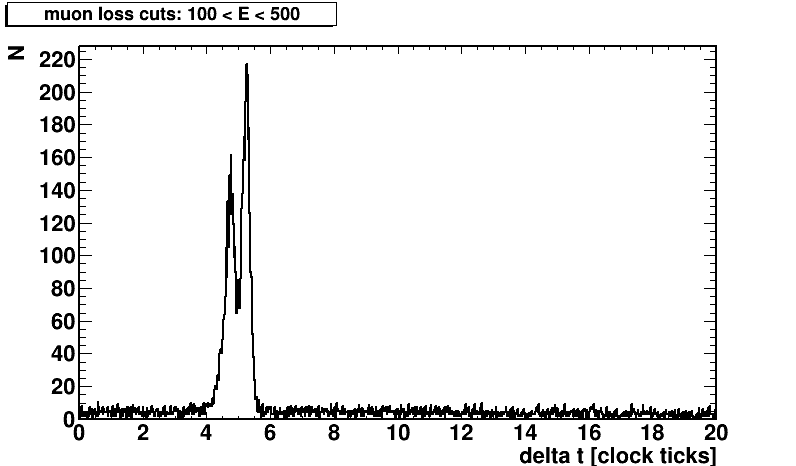

In [27]:
muonCutHistDouble=getDiffHistMuonCuts(1,'muonCutHistDouble')
muonCutHistDouble.Draw()
muonCutHistDouble.SetTitle('muon loss cuts: 100 < E < 500; delta t [clock ticks]; N')
c.Draw()
muonCutHistDouble.Integral(muonCutHistDouble.FindBin(4), muonCutHistDouble.FindBin(6))

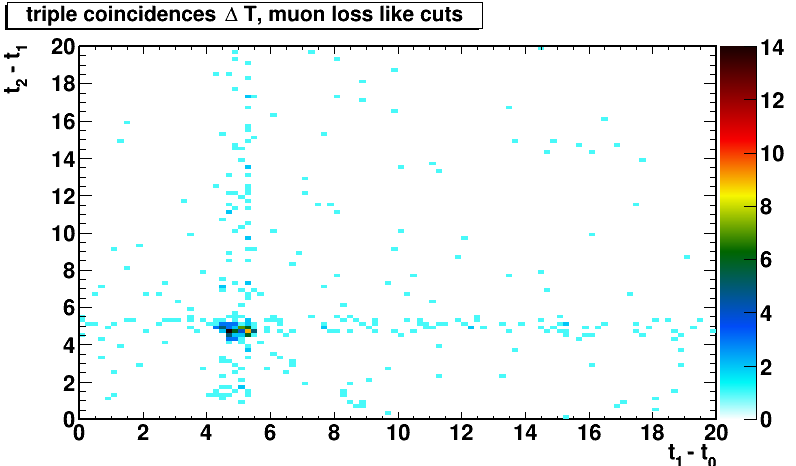

In [28]:
ecuts = ROOT.TCut()
ecuts = sum((ROOT.TCut('clusterEnergy[{0}]>100 && clusterEnergy[{1}]<500'.format(i,i)) for i in xrange(3)), ROOT.TCut())
t.Draw("clusterTime[2]-clusterTime[1]:clusterTime[1]-clusterTime[0]>>2dtimingsmuoncuts(100,0,20,100,0,20)", 
       CLevel(3)+CaloDiffCut((1,0),1)+CaloDiffCut((2,1),1)+ecuts,"colz")
muoncuts2d = ROOT.gROOT.FindObject('2dtimingsmuoncuts')
muoncuts2d.SetTitle('triple coincidences #Delta T, muon loss like cuts;t_{1} - t_{0}; t_{2} - t_{1}')
c.SetLogz(0)
c.Draw()

In [29]:
ecuts.GetTitle()

'((clusterEnergy[0]>100 && clusterEnergy[0]<500)&&(clusterEnergy[1]>100 && clusterEnergy[1]<500))&&(clusterEnergy[2]>100 && clusterEnergy[2]<500)'

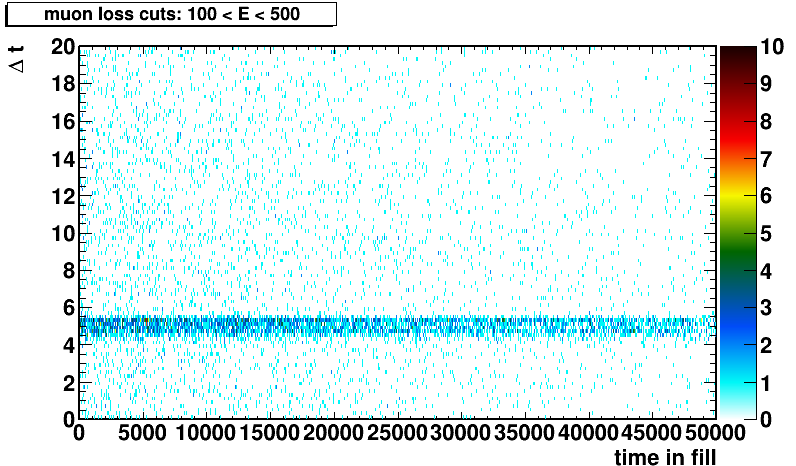

In [30]:
muonCutHistDouble2d=get2dHistMuonCuts(1,'muonCutHist2d')
muonCutHistDouble2d.Draw('colz')
muonCutHistDouble2d.SetTitle('muon loss cuts: 100 < E < 500; time in fill; #Delta t')
c.Draw()

In [31]:
muonCutHistDouble.Integral(muonCutHistDouble.FindBin(4), muonCutHistDouble.FindBin(6))

6364.0

In [32]:
(muonCutHistDouble.Integral(muonCutHistDouble.FindBin(4), muonCutHistDouble.FindBin(4.5)) +
 muonCutHistDouble.Integral(muonCutHistDouble.FindBin(5.5), muonCutHistDouble.FindBin(6))) / 380

1.9578947368421054

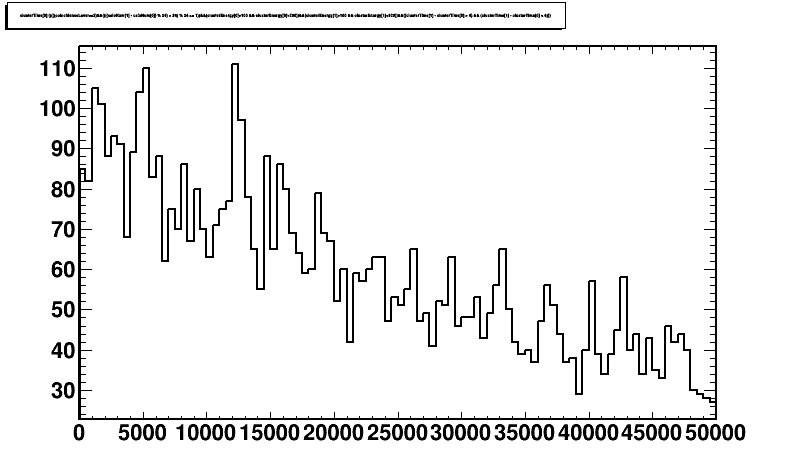

In [33]:
# probability of doubles
timeMC = timeMuonCuts('timeMC')
timeMC.Draw()
c.Draw()

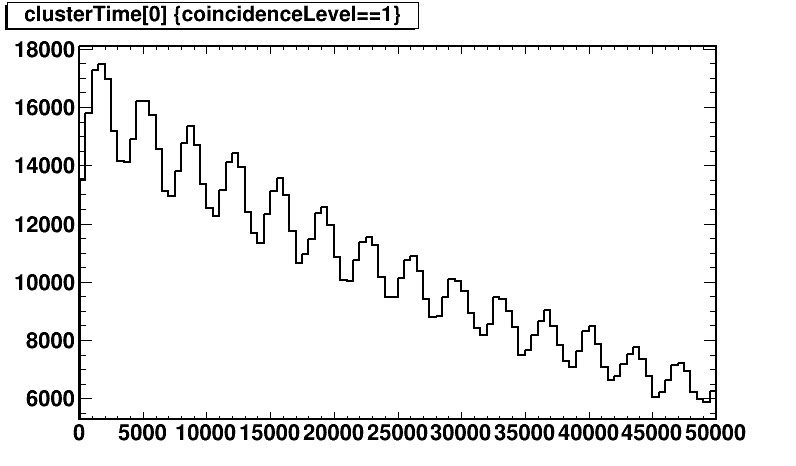

In [34]:
t.Draw("clusterTime[0]>>timeSingles(100,0,50000)",CLevel(1))
ts = ROOT.gROOT.FindObject('timeSingles')
ts.Draw()
c.Draw()

In [35]:
timeMC.Integral()

5950.0

In [36]:
probg = ROOT.TGraphErrors(0)
for i in xrange(1, timeMC.GetNbinsX() + 1):    
    nClusters = ts.GetBinContent(i)
    nCoins = float(timeMC.GetBinContent(i))
    probg.SetPoint(i-1, timeMC.GetBinCenter(i), nCoins/nClusters)
    probg.SetPointError(i-1, 0, math.sqrt(nCoins)/nClusters)

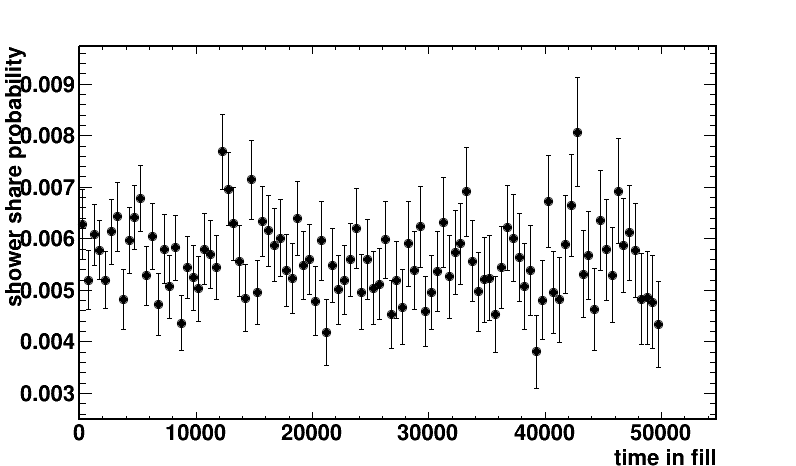

In [37]:
probg.Draw("ap")
probg.SetTitle(';time in fill; shower share probability')
probg.GetYaxis().SetTitleOffset(1)
c.Draw()

In [38]:
nClustersTot/380.0

2786.192105263158

In [39]:
def passed_muon_cuts(e):
    passed_energy = reduce(lambda x,y: x and y, (e.clusterEnergy[i] > 100 and e.clusterEnergy[i] < 500 
                           for i in range(2)))
    passed_time = e.clusterTime[1] - e.clusterTime[0] > 4 and e.clusterTime[1] - e.clusterTime[0] < 6
    return passed_energy and passed_time and (e.caloNum[1]-e.caloNum[0] + 24) % 24 == 1 

In [40]:
nDoubles = [0 for i in xrange(24)]
nClusters = [0 for i in xrange(24)]
for e in t:
    if e.coincidenceLevel == 1:
        nClusters[e.caloNum[0]] += 1
    if e.coincidenceLevel == 2 and passed_muon_cuts(e):
        nDoubles[e.caloNum[0]] += 1   

In [41]:
import math
caloNumProb = ROOT.TGraphErrors(0)
for i, (doubs, clusts) in enumerate(zip(nDoubles, nClusters)):
    caloNumProb.SetPoint(i, i+1, doubs/float(clusts))
    caloNumProb.SetPointError(i, 0, math.sqrt(doubs)/clusts)
caloNumProb.SetTitle(';calo num; shower share probability')

## probability by calo number

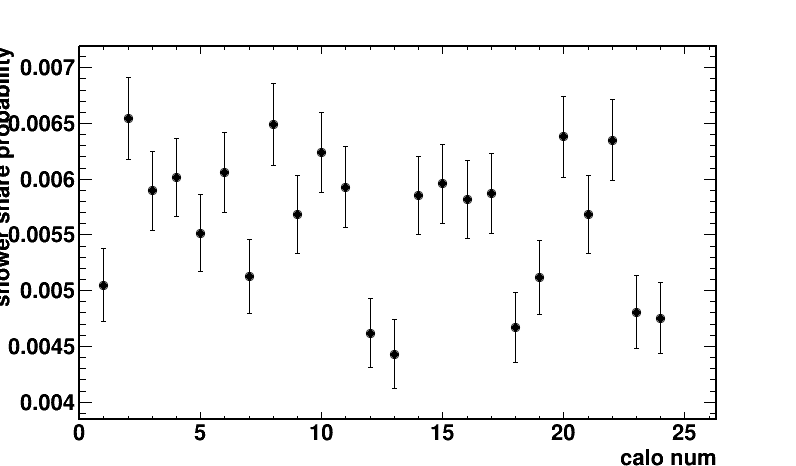

In [42]:
caloNumProb.Draw('ap')
caloNumProb.GetYaxis().SetTitleOffset(1.2)
c.Draw()